# 01_preprocess.ipynb — (clean + align + split)

## 0. Notebook Setup & Paths

In [20]:
import numpy as np, pandas as pd, random, json
from pathlib import Path
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [21]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED)

In [22]:
# Project paths
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_INTERIM = PROJECT_ROOT / "data" / "interim"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
REPORTS = PROJECT_ROOT / "reports"
FIGS = PROJECT_ROOT / "reports" / "figures"
MODELS = PROJECT_ROOT / "models"

# Create folders (including DATA_RAW to be safe)
for d in (DATA_RAW, DATA_INTERIM, DATA_PROCESSED, REPORTS, FIGS, MODELS):
    d.mkdir(parents=True, exist_ok=True)

# Raw inputs
expr_path   = DATA_RAW / "TCGA-BRCA.HiSeqV2.gz"
pheno_path  = DATA_RAW / "TCGA-BRCA.GDC_phenotype.tsv"

# Load data
expr_df  = pd.read_csv(expr_path, sep="\t", compression="infer", low_memory=False)
pheno_df = pd.read_csv(pheno_path, sep="\t", low_memory=False)


# Verify project structure & data files ---
print("✓ Paths ready\n")
print(f"📂 PROJECT_ROOT : {PROJECT_ROOT}")
print(f"📄 Expression file : {'✅ Found' if expr_path.exists() else '❌ Missing'} → {expr_path.name}")
print(f"📄 Phenotype file  : {'✅ Found' if pheno_path.exists() else '❌ Missing'} → {pheno_path.name}")

print("\nDataFrames Loaded:")
print(f"   Expression: {expr_df.shape}")
print(f"   Phenotype : {pheno_df.shape}")



✓ Paths ready

📂 PROJECT_ROOT : c:\Projects\BRCATranstypia
📄 Expression file : ✅ Found → TCGA-BRCA.HiSeqV2.gz
📄 Phenotype file  : ✅ Found → TCGA-BRCA.GDC_phenotype.tsv

DataFrames Loaded:
   Expression: (20530, 1219)
   Phenotype : (1247, 194)


# 1. Inspect phenotype schema;Locate ID / Subtype Columns 

In [23]:
# (1.1) Quick glance at columns and basic info ---
print("pheno_df columns (count =", len(pheno_df.columns), "):")
print(list(pheno_df.columns)[:10]) 

pheno_df columns (count = 194 ):
['sampleID', 'AJCC_Stage_nature2012', 'Age_at_Initial_Pathologic_Diagnosis_nature2012', 'CN_Clusters_nature2012', 'Converted_Stage_nature2012', 'Days_to_Date_of_Last_Contact_nature2012', 'Days_to_date_of_Death_nature2012', 'ER_Status_nature2012', 'Gender_nature2012', 'HER2_Final_Status_nature2012']


In [24]:
# (1.2) Heuristics to propose candidate columns 
# ID-like columns commonly used in TCGA phenotype
id_candidates = [c for c in pheno_df.columns
                 if any(k in c.lower() for k in ['barcode', 'sample', 'submitter', 'bcr_sample', 'case', 'submitter_id'])]

# Subtype-like columns that may carry PAM50/intrinsic subtype labels
subtype_candidates = [c for c in pheno_df.columns
                      if any(k in c.lower() for k in ['pam50', 'subtype', 'intrinsic'])]

print("\nCandidate ID columns:", id_candidates or "(none found yet)")
print("Candidate Subtype columns:", subtype_candidates or "(none found yet)")



Candidate ID columns: ['sampleID', 'bcr_followup_barcode', 'bcr_patient_barcode', 'bcr_sample_barcode', 'followup_case_report_form_submission_reason', 'sample_type', 'sample_type_id']
Candidate Subtype columns: ['Integrated_Clusters_with_PAM50__nature2012', 'PAM50Call_RNAseq', 'PAM50_mRNA_nature2012', 'SigClust_Intrinsic_mRNA_nature2012']


In [25]:
# (1-3) Save candidate columns to inspect 
out_dir = DATA_INTERIM / "candidates"
out_dir.mkdir(parents=True, exist_ok=True)

# Save first 10 non-NA values from each column
for cols, name in [(id_candidates, "id_candidates"), (subtype_candidates, "subtype_candidates")]:
    df_nonempty = pd.concat(
        [pheno_df[c].dropna().head(10).reset_index(drop=True).rename(c) for c in cols],
        axis=1
    )
    df_nonempty.to_csv(out_dir / f"{name}_preview.csv", index=False)

print(f"✅ Saved non-empty previews to {out_dir}")

✅ Saved non-empty previews to c:\Projects\BRCATranstypia\data\interim\candidates


In [26]:
# (1.4) picking the most likely candidates after manual inspection
ID_COL  = "sampleID"            # sample-level ID, matches expression column names
SUB_COL = "PAM50Call_RNAseq"   # RNA-seq PAM50 subtype labels
PATIENT_COL  = "bcr_patient_barcode" # patient-level ID, for group splitting

print("\nChosen ID_COL :", ID_COL)
print("Chosen SUB_COL:", SUB_COL)
print("Chosen PATIENT_COL:", PATIENT_COL)


Chosen ID_COL : sampleID
Chosen SUB_COL: PAM50Call_RNAseq
Chosen PATIENT_COL: bcr_patient_barcode


# 2- Normalize IDs + compute patient IDs


In [27]:
# (2.1) Helpers for ID cleaning and TCGA patient ID extraction ---
def normalize_id(x):
    # TCGA barcodes sometimes have '.' — standardize to '-'
    if pd.isna(x): return x
    return str(x).strip().replace('.', '-')

def tcga_patient_id(barcode):
    # Patient-level ID = first 12 chars of TCGA barcode (e.g., TCGA-AB-1234)
    if pd.isna(barcode): return barcode
    return str(barcode).replace('.', '-')[:12]


In [28]:
# (2.2) Normalize the chosen ID column in phenotype ---
pheno_df = pheno_df.copy()
pheno_df[ID_COL] = pheno_df[ID_COL].map(normalize_id)
pheno_df["patient_id"] = pheno_df[ID_COL].map(tcga_patient_id)

print("ID preview:", pheno_df[ID_COL].dropna().astype(str).head(3).tolist())
print("patient_id preview:", pheno_df["patient_id"].dropna().astype(str).head(3).tolist())

ID preview: ['TCGA-3C-AAAU-01', 'TCGA-3C-AALI-01', 'TCGA-3C-AALJ-01']
patient_id preview: ['TCGA-3C-AAAU', 'TCGA-3C-AALI', 'TCGA-3C-AALJ']


# 3. Build labels table

In [29]:
# (3.1) Subtype mapping dictionary (covers common variants)
SUBTYPE_MAP = {
    "Luminal A":"LumA", "Luminal B":"LumB", "HER2-enriched":"HER2", "Basal-like":"Basal",
    "LumA":"LumA", "LumB":"LumB", "HER2":"HER2", "Basal":"Basal",
    "Her2":"HER2", "HER2 enriched":"HER2", "Basal like":"Basal",
    "Basal-like (Basal)":"Basal"
}

def map_subtype(x):
    if pd.isna(x): return np.nan
    return SUBTYPE_MAP.get(str(x).strip(), np.nan)


In [30]:
# (3.2) Build a compact labels table (if SUB_COL is available) ---
labels_df = (
    pheno_df[[ID_COL, "patient_id", SUB_COL]]
      .assign(
          subtype_raw=lambda d: d[SUB_COL].astype(str).str.strip(),
          subtype_mapped=lambda d: d["subtype_raw"].map(map_subtype)
      )
      .loc[lambda d: d["subtype_raw"].str.lower() != "normal"]    # drop Normal/Normal-like
      .dropna(subset=["subtype_mapped"])
      .reset_index(drop=True)
)

print("✅ Labels ready:", labels_df.shape)
print(labels_df["subtype_mapped"].value_counts())


✅ Labels ready: (837, 5)
subtype_mapped
LumA     434
LumB     194
Basal    142
HER2      67
Name: count, dtype: int64


# 4.Prepare the expression matrix as samples × genes

In [31]:
expr_df = expr_df.copy()

# Heuristic: if first column looks like gene symbols, treat it as gene column and transpose
first_col = expr_df.columns[0]
first_col_looks_like_gene = ('gene' in first_col.lower()) or (expr_df[first_col].astype(str).str.contains('-').mean() < 0.05)

if first_col_looks_like_gene:
    # assume first column is gene id/name
    expr_df = expr_df.set_index(first_col).T.reset_index().rename(columns={'index':'sample_id'})
else:
    if expr_df.index.name is None:
        expr_df.index.name = 'sample_id'
    expr_df = expr_df.reset_index().rename(columns={expr_df.index.name or 'index':'sample_id'})

expr_df["sample_id"] = expr_df["sample_id"].map(normalize_id)

print("Expression table:", expr_df.shape)
print("Has 'sample_id' column?", 'sample_id' in expr_df.columns)
print("sample_id preview:", expr_df["sample_id"].head(3).tolist())

Expression table: (1218, 20531)
Has 'sample_id' column? True
sample_id preview: ['TCGA-AR-A5QQ-01', 'TCGA-D8-A1JA-01', 'TCGA-BH-A0BQ-01']


# 5.Align labels to expression


In [32]:

if labels_df is None:
    raise RuntimeError("No labels_df (no SUB_COL in phenotype). Compute PAM50 from expression first, then rerun.")

merged = labels_df[[ID_COL, "patient_id", "subtype_mapped"]].merge(
    expr_df, left_on=ID_COL, right_on="sample_id", how="inner"
)
print("Merged shape:", merged.shape)
print("Class counts after merge:\n", merged["subtype_mapped"].value_counts())


Merged shape: (837, 20534)
Class counts after merge:
 subtype_mapped
LumA     434
LumB     194
Basal    142
HER2      67
Name: count, dtype: int64


In [33]:
# Quick leakage sanity
dup_patients = merged["patient_id"].value_counts()
print("Patients with >1 samples:", (dup_patients > 1).sum())
dup_patients.head(5)

Patients with >1 samples: 16


patient_id
TCGA-A7-A13G    2
TCGA-GI-A2C8    2
TCGA-BH-A0B5    2
TCGA-BH-A0DD    2
TCGA-BH-A0DK    2
Name: count, dtype: int64

# 6. Patient-level stratified split (no leakage)

In [34]:
# 6. Stratified patient-level split ---
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

X = merged.drop(columns=['sample_id','patient_id','subtype_mapped'])
y = merged['subtype_mapped']
g = merged['patient_id']

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, temp_idx = next(cv.split(X, y, g))

X_train, y_train, g_train = X.iloc[train_idx], y.iloc[train_idx], g.iloc[train_idx]
X_temp,  y_temp,  g_temp  = X.iloc[temp_idx],  y.iloc[temp_idx],  g.iloc[temp_idx]

rng = np.random.RandomState(42)
groups = pd.Series(g_temp.unique()).sample(frac=1, random_state=42).tolist()
val_groups = set(groups[:len(groups)//2])
test_groups = set(groups[len(groups)//2:])

val_mask = g_temp.isin(val_groups)
test_mask = g_temp.isin(test_groups)

X_val, y_val = X_temp[val_mask], y_temp[val_mask]
X_test, y_test = X_temp[test_mask], y_temp[test_mask]

print("Split sizes:")
for name, yy in zip(["Train","Val","Test"], [y_train,y_val,y_test]):
    print(f"  {name:<5} {yy.shape[0]:4d} samples →", yy.value_counts().to_dict())


Split sizes:
  Train  671 samples → {'LumA': 350, 'LumB': 156, 'Basal': 115, 'HER2': 50}
  Val     82 samples → {'LumA': 40, 'LumB': 21, 'Basal': 13, 'HER2': 8}
  Test    84 samples → {'LumA': 44, 'LumB': 17, 'Basal': 14, 'HER2': 9}


# 7. Normalize features (log1p + z-score) ---

In [35]:
from sklearn.preprocessing import StandardScaler

APPLY_LOG1P = True
TOP_N_VAR = 5000  # or None

def maybe_log1p(df):
    num = df.select_dtypes(include=[np.number])
    other = df.drop(columns=num.columns, errors='ignore')
    num = np.log1p(num.clip(lower=0)) if APPLY_LOG1P else num
    return pd.concat([num, other], axis=1)[df.columns]

Xt = {'train': maybe_log1p(X_train), 'val': maybe_log1p(X_val), 'test': maybe_log1p(X_test)}

if TOP_N_VAR:
    # keep only numeric columns before variance
     num_cols = Xt['train'].select_dtypes(include=[np.number])
     keep = num_cols.var().sort_values(ascending=False).head(TOP_N_VAR).index
else:
    keep = Xt['train'].columns

Xt = {k: v[keep] for k,v in Xt.items()}

scaler = StandardScaler()
Xz = {
    k: pd.DataFrame(scaler.fit_transform(v) if k=='train' else scaler.transform(v),
                    columns=keep, index=v.index)
    for k,v in Xt.items()
}
print("Features kept:", len(keep))


Features kept: 5000


# 8. Save processed data

In [36]:
PROC = DATA_PROCESSED
PROC.mkdir(parents=True, exist_ok=True)

Xz['train'].to_csv(PROC/'X_train.csv', index=False)
Xz['val'  ].to_csv(PROC/'X_val.csv', index=False)
Xz['test' ].to_csv(PROC/'X_test.csv', index=False)


y_train.to_frame('subtype').to_csv(PROC/'y_train.csv', index=False)
y_val.to_frame('subtype').to_csv(PROC/'y_val.csv', index=False)
y_test.to_frame('subtype').to_csv(PROC/'y_test.csv', index=False)

meta = dict(seed=42, apply_log1p=APPLY_LOG1P, top_n_var=TOP_N_VAR, n_features=len(keep))
pd.Series(meta).to_json(PROC/'meta.json')

print(f"✅ Saved all processed data to: {PROC}")


✅ Saved all processed data to: c:\Projects\BRCATranstypia\data\processed


Sanity plots

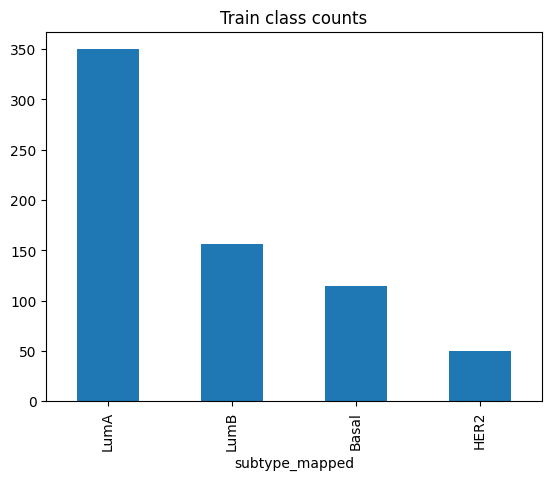

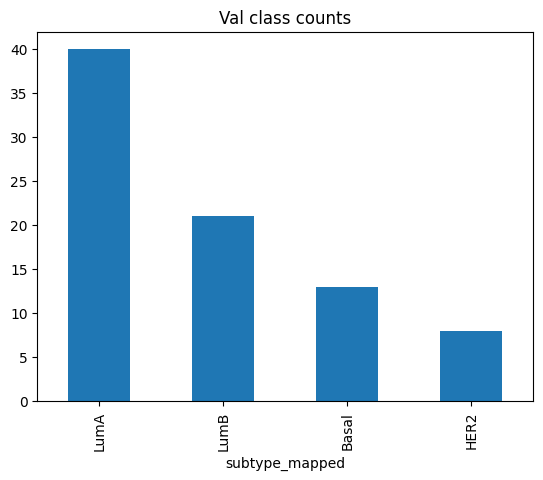

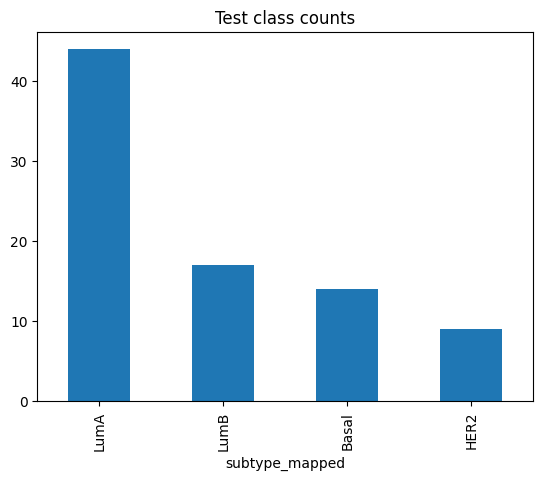

In [37]:
import matplotlib.pyplot as plt
for name, yy in [("Train",y_train),("Val",y_val),("Test",y_test)]:
    plt.figure(); yy.value_counts().plot(kind='bar'); plt.title(f"{name} class counts"); plt.show()

Summary

In [38]:
print(f"Features: {len(keep)} | log1p: {APPLY_LOG1P} | topN: {TOP_N_VAR}")
print("Shapes:", 
      "Train", Xz['train'].shape, 
      "| Val", Xz['val'].shape, 
      "| Test", Xz['test'].shape)


Features: 5000 | log1p: True | topN: 5000
Shapes: Train (671, 5000) | Val (82, 5000) | Test (84, 5000)
